# Depth Estimation

In this Jupyter Notebook, we attempt to generate the smaller model with the best accuracy that would fit in the Pynq-Z2. We compare the model generated here with our previous model created in `FINN_depth_estimation`.

For this part of the notebook, the user must download the DIODE dataset (~81GB training and ~2GB evaluation) at this link: https://diode-dataset.org/

Furthermore, the user should create an Anaconda environment containing all the hls4ml dependencies. We used the hls4ml-training repository: https://github.com/fastmachinelearning/hls4ml-tutorial

## Imports

In [142]:
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['PATH'] = os.environ['XILINX_VITIS'] + '/bin:' + os.environ['PATH']

In [143]:
import sys
import cv2
from PIL import Image

In [144]:
import tensorflow.keras.models as models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, UpSampling2D
from qkeras.qlayers import QDense, QActivation
from qkeras import QConv2D, QConv2DBatchnorm
from qkeras.quantizers import quantized_bits, quantized_relu

In [145]:
import pandas as pd
from qkeras import QDense, QConv2D, QActivation, QBatchNormalization
from qkeras.utils import model_quantize
from PIL import Image

In [146]:
from qkeras import QConv2D, quantized_bits, quantized_relu

In [162]:
from IPython.display import clear_output

## Training and validation data

Here, the user should change the variables according to the paths of the DIODE dataset. The maximum sizes allow to train the model on little training data.

In [147]:
root = os.getcwd()

folder = "val"

path_eval = os.path.join(root, "val")
path_train = "/tools/diode"

max_train_size = 3000000
max_eval_size = 500000000

In [148]:
size = 32
target_size = (size, size)
modelname = f"depth_{size}.keras"
batch_size = 16

## Load data

Here we load the validation data and read the training directory.

In [150]:
filelist_train = []
for root, dirs, files in os.walk(path_train):
    for file in files:
        filelist_train.append(os.path.join(root, file))

In [151]:
filelist_train.sort()
data = {
    "image": [x for x in filelist_train if x.endswith(".png")][:max_train_size],
    "depth": [x for x in filelist_train if x.endswith("_depth.npy")][:max_train_size],
    "mask_": [x for x in filelist_train if x.endswith("_depth_mask.npy")][:max_train_size],
}
df = pd.DataFrame(data)
df = df.sample(frac=1, random_state=42)

In [152]:
len(data["image"])

25458

In [153]:
filelist_eval = []
for root, dirs, files in os.walk(path_eval):
    for file in files:
        filelist_eval.append(os.path.join(root, file))

In [154]:
filelist_eval.sort()
data_eval = {
    "image": [x for x in filelist_eval if x.endswith(".png")][:max_eval_size],
    "depth": [x for x in filelist_eval if x.endswith("_depth.npy")][:max_eval_size],
    "mask_": [x for x in filelist_eval if x.endswith("_depth_mask.npy")][:max_eval_size],
}

In [155]:
len(data_eval["image"])

771

In [159]:
X = []
for x_path in data_eval["image"]:
    img = tf.keras.preprocessing.image.load_img(x_path, target_size=(size, size, 3))
    img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    X.append(img)
X = np.stack(X, axis=0) 

In [160]:
Y = []
i = 0
for d_path in data_eval["depth"]:
    
    depth = np.load(d_path).astype(np.float32)
    
    depth_mask = np.load(data_eval['mask_'][i]).astype(np.float32).squeeze()
    depth[depth_mask == 0] = np.mean(depth)
    depth = (depth - 0.3) / (30.0 - 0.3)
    depth = np.clip(depth, 0.0, 1.0)
    
    depth = tf.image.resize(depth, (size, size))
    depth = tf.keras.preprocessing.image.img_to_array(depth)
    
    Y.append(depth)
    
    i += 1
Y = np.stack(Y, axis=0)

## Create a model

Creating a model that respects the U-Net architecture and has a correct accuracy has to be done empirically according to the resource usage after Vitis HLS synthesis. In this example, we use two 4 filters convolutions for the encoder, a 8 filters convolution for the bottleneck and two 4 filters convolutions for the decoder. Eventually we use an element-wise convolution for the output.

In [156]:
"""
64
70.8984962406015% LUT Usage
93.21428571428572% BRAM_18K Usage
2.727272727272727% DSP Usage
24.48872180451128% FF Usage
0.0% URAM Usage

32

56.47932330827068% LUT Usage
42.857142857142854% BRAM_18K Usage
2.727272727272727% DSP Usage
21.87218045112782% FF Usage
0.0% URAM Usage

32 8-16-32
177.76127819548873% LUT Usage
162.85714285714286% BRAM_18K Usage
2.727272727272727% DSP Usage
70.10526315789474% FF Usage
0.0% URAM Usage

32 4-8-16-8-4
90.72744360902256% LUT Usage
83.21428571428572% BRAM_18K Usage
2.727272727272727% DSP Usage
40.088345864661655% FF Usage
0.0% URAM Usage
"""
def unet_model(input_shape=(size, size, 3)):
    
    inputs = layers.Input(shape=input_shape)

    c0 = layers.Conv2D(4, 3, padding='same', activation='relu')(inputs)
    p0 = layers.MaxPooling2D((2, 2))(c0)
    
    c1 = layers.Conv2D(8, 3, padding='same', activation='relu')(p0)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(16, 3, padding='same', activation='relu')(p1)
    
    c3 = layers.Conv2D(8, 3, padding='same', activation='relu')(c2)
    c3 = layers.UpSampling2D(size=(2, 2))(c3)
    u3 = layers.concatenate([c1, c3])
    
    c4 = layers.Conv2D(4, 3, padding='same', activation='relu')(u3)
    c4 = layers.UpSampling2D(size=(2, 2))(c4)
    u4 = layers.concatenate([c0, c4])
    
    c5 = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(u4)

    model = models.Model(inputs=inputs, outputs=c5)
    return model

## Model compilation

To compile the model, we can use various loss functions such as MSE, MAE or SSIM. We define SSIM if the user want to further explore it.

SSIM stands for Structural Similarity Index and evaluates the similarity between two images.

In [157]:
def ssim_loss(y_true, y_pred):
    return 1.0 - tf.reduce_mean(
        tf.image.ssim(y_true, y_pred, max_val=tf.reduce_max(y_true))
    )

def combined_ssim_loss(y_true, y_pred, alpha=1.0, beta=1.0, gamma=0.5):

    mse = tf.reduce_mean(tf.square(y_true - y_pred))

    dy_t, dx_t = tf.image.image_gradients(y_true)
    dy_p, dx_p = tf.image.image_gradients(y_pred)
    grad_loss = tf.reduce_mean(tf.abs(dy_t - dy_p) + tf.abs(dx_t - dx_p))

    ssim_l = ssim_loss(y_true, y_pred)
    return alpha * mse + beta * grad_loss + gamma * ssim_l

def ssim_mse_loss(y_true, y_pred):
    return combined_ssim_loss(y_true, y_pred, alpha=1.0, beta=1.0, gamma=0.5)

We compile our model using the Adam algorithm and use the MSE loss function. To evaluate the evaluations, we use MAE.

In [169]:
model = unet_model(input_shape=(size, size, 3))

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss="mse",
    metrics=["mae"],
)

model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_42 (Conv2D)          (None, 32, 32, 4)            112       ['input_11[0][0]']            
                                                                                                  
 max_pooling2d_18 (MaxPooli  (None, 16, 16, 4)            0         ['conv2d_42[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_43 (Conv2D)          (None, 16, 16, 8)            296       ['max_pooling2d_18[0][0

## Dynamic learning data loading

To avoid loading all the learning data in the RAM, we use a dynamic data generator.

In [161]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, target_size=(256, 256), batch_size=32, shuffle=True):
        self.data = dataframe
        self.target_size = target_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.data))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = self.data.iloc[batch_indices]
        X, Y = self.__data_generation(batch_data)
        return X, Y

    def __data_generation(self, batch_data):
        X = []
        Y = []
        for i, row in batch_data.iterrows():
            img = tf.keras.preprocessing.image.load_img(
                row["image"], target_size=(self.target_size[0], self.target_size[1])
            )
            img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            X.append(img)

            depth = np.load(row["depth"]).astype(np.float32)

            depth_mask = np.load(row['mask_']).astype(np.float32).squeeze()
            depth[depth_mask == 0] = np.mean(depth)

            depth = (depth - 0.3) / (30.0 - 0.3)
            depth = np.clip(depth, 0.0, 1.0)
            depth = tf.image.resize(depth, (self.target_size[0], self.target_size[1]))
            depth = tf.keras.preprocessing.image.img_to_array(depth)
            Y.append(depth)

        X = np.stack(X, axis=0)
        Y = np.stack(Y, axis=0)
        return X, Y

In [ ]:
df = pd.DataFrame(data)
df = df.sample(frac=1, random_state=42)
training_generator = DataGenerator(df, target_size=target_size, batch_size=batch_size)

## Dynamic plotting

To prevent over-fitting, we can observe the learning and the evaluation graphs and stop the learning process when needed.

In [163]:
class LivePlotCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_val, Y_val):
        super().__init__()
        self.X_val = X_val
        self.Y_val = Y_val
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.train_losses.append(logs.get('loss'))
        self.train_accuracies.append(logs.get('accuracy'))

        val_loss, val_acc = self.model.evaluate(self.X_val, self.Y_val, verbose=0)
        self.val_losses.append(val_loss)
        self.val_accuracies.append(val_acc)

        clear_output(wait=True)
        epochs = range(1, len(self.train_losses) + 1)

        plt.figure(figsize=(14, 5))

        # loss plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label='Training Loss')
        plt.plot(epochs, self.val_losses, label='Evaluation Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_accuracies, label='Training Error')
        plt.plot(epochs, self.val_accuracies, label='Evaluation Error')
        plt.title('Error over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Error')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

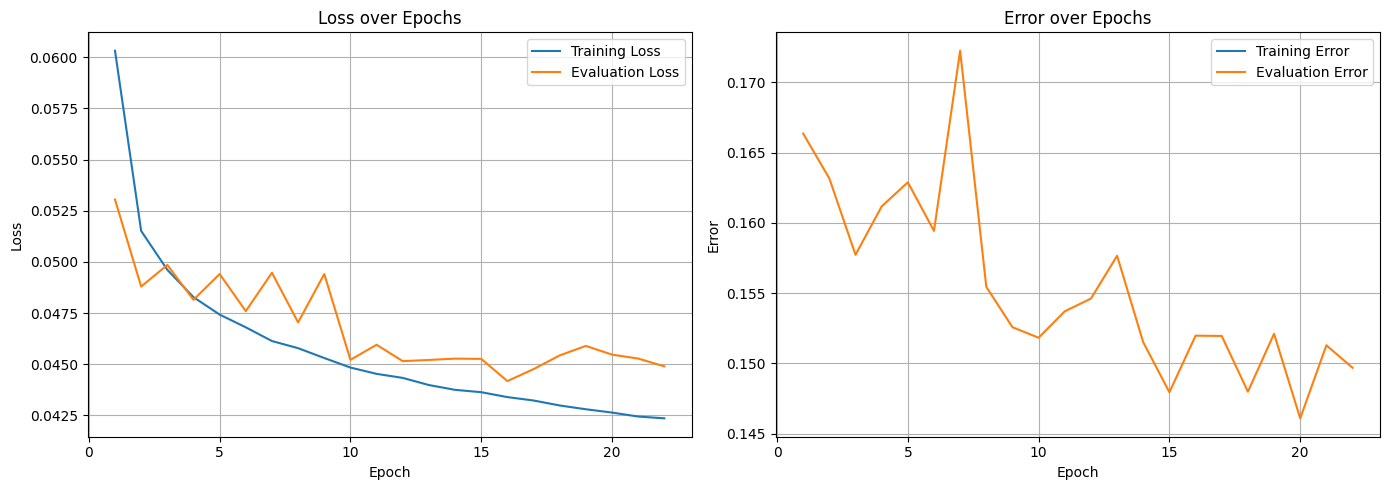

1592/1592 [==============================] - 1379s 866ms/step - loss: 0.0424 - mae: 0.1428
Epoch 23/10000
   9/1592 [..............................] - ETA: 21:12 - loss: 0.0409 - mae: 0.1375

KeyboardInterrupt: 

In [170]:
live_plot_cb = LivePlotCallback(X, Y)

history = model.fit(
    training_generator,
    epochs=10000,
    batch_size=batch_size,
    callbacks=[
        live_plot_cb,
        tf.keras.callbacks.ModelCheckpoint(modelname)
    ]
)

## Validation using images

In this part of the notebook, we evaluate the performance of the trained model on unseen images.

In [ ]:
from keras.saving import load_model
from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)
model = load_model(modelname, custom_objects=co, safe_mode=False)
model.summary()

In [ ]:
for weight in model.weights:
    print(f"Name: {weight.name}")
    print(f"Shape: {weight.shape}")
    print(weight.numpy())

### DIODE image

Here we use an image provided in the evaluation part of the DIODE dataset.

1/1 [==============================] - 0s 13ms/step


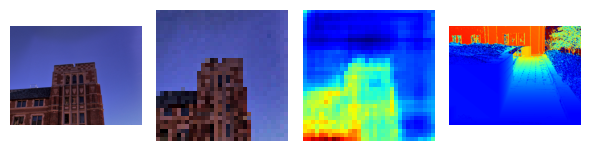

In [248]:
img = tf.keras.preprocessing.image.load_img(
    "./val/outdoor/scene_00022/scan_00193/00022_00193_outdoor_000_040.png",
    target_size=(size, size)
)
img = tf.keras.preprocessing.image.img_to_array(img) / 255.0  

img_batch = tf.expand_dims(img, axis=0)
res_batch = model.predict(img_batch)

im = res_batch[0, :, :, 0]

fig, axes = plt.subplots(1, 4, figsize=(6, 3))

axes[2].imshow(im, cmap='jet')
axes[2].axis('off')

axes[1].imshow(img, cmap='jet')
axes[1].axis('off')

axes[0].imshow(tf.keras.preprocessing.image.load_img(
    "./val/outdoor/scene_00022/scan_00193/00022_00193_outdoor_000_040.png",
), cmap='jet')
axes[0].axis('off')

axes[3].imshow(np.clip(np.load("./val/outdoor/scene_00022/scan_00193/00022_00193_outdoor_000_000_depth.npy"), 0, 30), cmap='jet')
axes[3].axis('off')

plt.tight_layout()
plt.show()

### Outdoor image

Here we use an image of the landscape seen outside of one of the UMons SEMi's windows.

1/1 [==============================] - 0s 15ms/step


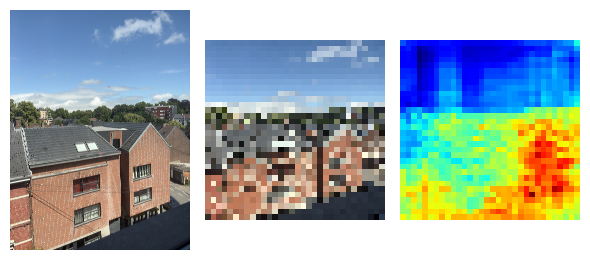

In [238]:
img = tf.keras.preprocessing.image.load_img(
    "IMG_1087.jpg",
    target_size=(size, size)
)
img = tf.keras.preprocessing.image.img_to_array(img) / 255.0  

img_batch = tf.expand_dims(img, axis=0)
res_batch = model.predict(img_batch)

im = res_batch[0, :, :, 0]

fig, axes = plt.subplots(1, 3, figsize=(6, 3))

axes[2].imshow(np.rot90(im, k=3), cmap='jet')
axes[2].axis('off')

axes[1].imshow(np.rot90(img, k=3), cmap='jet')
axes[1].axis('off')

axes[0].imshow(np.rot90(tf.keras.preprocessing.image.load_img(
    "IMG_1087.jpg",
), k=3), cmap='jet')
axes[0].axis('off')

plt.tight_layout()
plt.show()

## hls4ml

In this part, we use hls4ml to synthetise and implement our model for the Pynq-Z2.

**Important:** hls4ml currently only supports 2020.1 tools so it is import to `source` the correct Vivado installation.

In [186]:
import hls4ml
import plotting

config = hls4ml.utils.config_from_keras_model(model, granularity='model')
config['Model']['Precision']['default'] = 'ap_fixed<16,6>'
config['Model']['ReuseFactor'] = 4_000_000_000_000
config['Model']['Strategy'] = 'Resource'

print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")

hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config,
    output_dir='pynqz2m2/hls4ml_prj_pynq',
    backend='VivadoAccelerator',
    board='pynq-z2',
    io_type='io_stream'
)
hls_model.compile()

Interpreting Model
Topology:
Layer name: input_11, layer type: InputLayer, input shapes: [[None, 32, 32, 3]], output shape: [None, 32, 32, 3]
Layer name: conv2d_42, layer type: Conv2D, input shapes: [[None, 32, 32, 3]], output shape: [None, 32, 32, 4]
Layer name: max_pooling2d_18, layer type: MaxPooling2D, input shapes: [[None, 32, 32, 4]], output shape: [None, 16, 16, 4]
Layer name: conv2d_43, layer type: Conv2D, input shapes: [[None, 16, 16, 4]], output shape: [None, 16, 16, 8]
Layer name: max_pooling2d_19, layer type: MaxPooling2D, input shapes: [[None, 16, 16, 8]], output shape: [None, 8, 8, 8]
Layer name: conv2d_44, layer type: Conv2D, input shapes: [[None, 8, 8, 8]], output shape: [None, 8, 8, 16]
Layer name: conv2d_45, layer type: Conv2D, input shapes: [[None, 8, 8, 16]], output shape: [None, 8, 8, 8]
Layer name: up_sampling2d_17, layer type: UpSampling2D, input shapes: [[None, 8, 8, 8]], output shape: [None, 16, 16, 8]
Layer name: concatenate_17, layer type: Concatenate, input 

## Comparison between real model and quantized model (CPU)

hls4ml allows us to compare the output model.

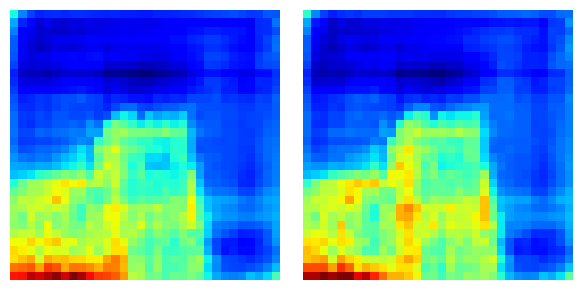

In [252]:
img_hls = tf.keras.preprocessing.image.load_img(
    "./val/outdoor/scene_00022/scan_00193/00022_00193_outdoor_000_040.png",
    target_size=(size, size)
)
img_hls = tf.keras.preprocessing.image.img_to_array(img_hls) / 255.0  

img_batch_hls = tf.expand_dims(img_hls, axis=0)
hls_im = hls_model.predict(img_batch_hls.numpy()).reshape((size, size, 1))

fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[1].imshow(hls_im, cmap='jet')
axes[1].axis('off')

axes[0].imshow(im, cmap='jet')
axes[0].axis('off')

plt.tight_layout()
plt.show()

In [249]:
plotting.print_dict(hls4ml.backends.get_backend('Vitis').create_initial_config())

Part:                xcvu13p-flga2577-2-e
ClockPeriod:         5
ClockUncertainty:    27%
IOType:              io_parallel
HLSConfig
WriterConfig
  Namespace:         None
  WriteWeightsTxt:   True
  WriteTar:          False


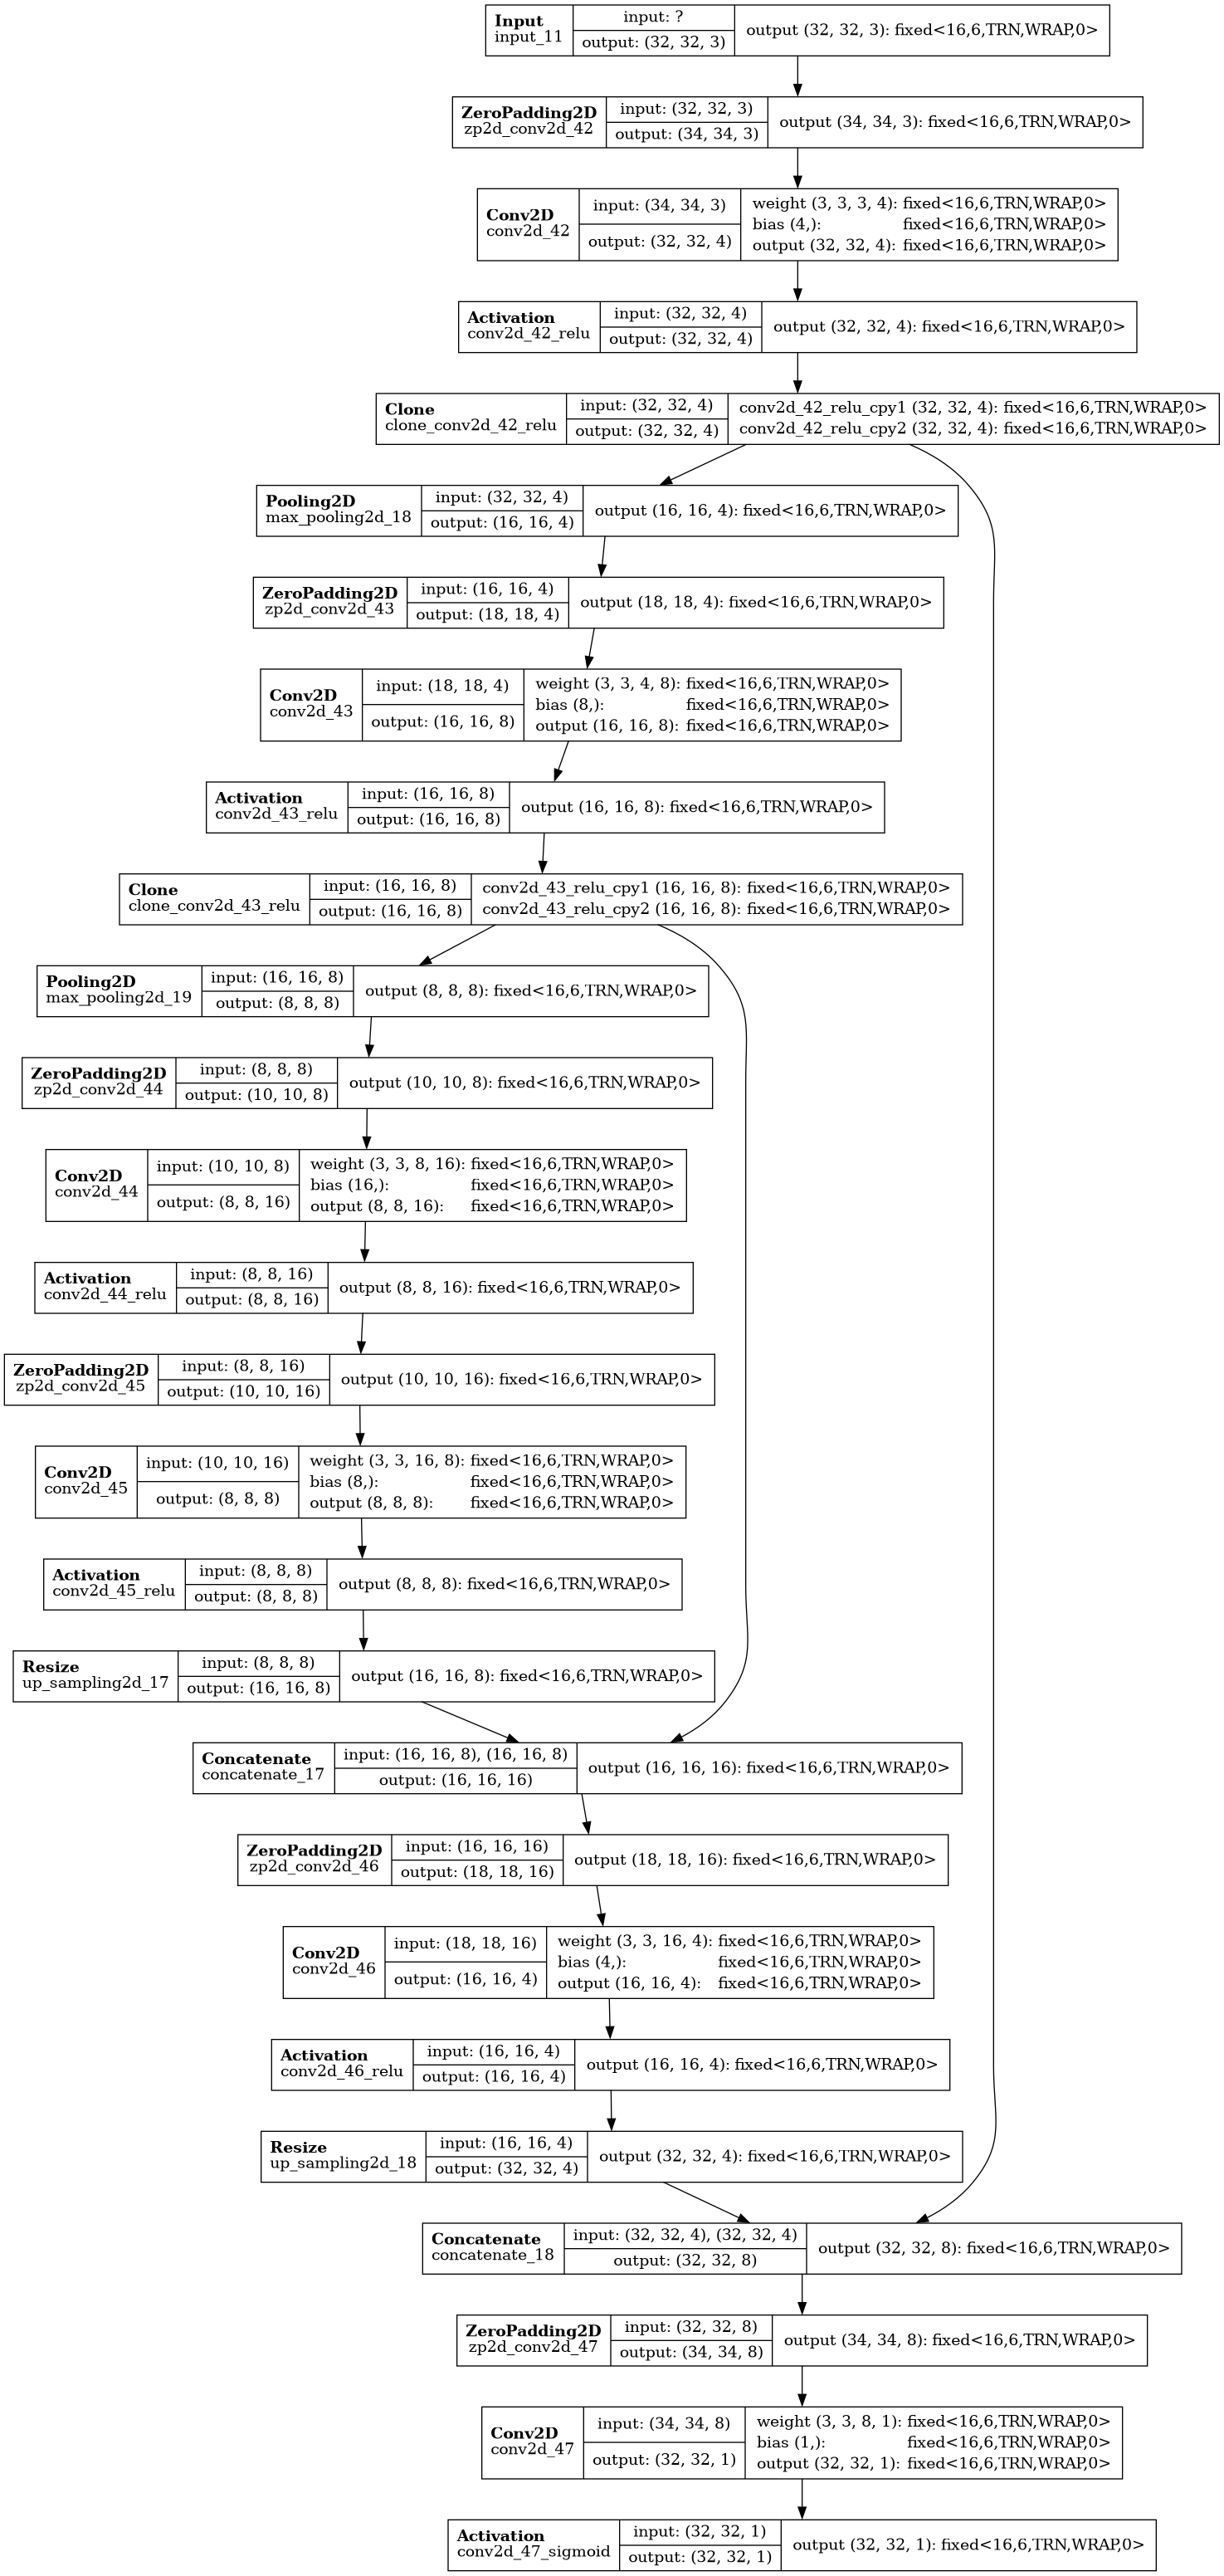

In [250]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

## Synthetise and Implement

We use `build` to run the synthesis and the implementation. After this we can retrieve the `.bit` and `.hwh` files.

In [190]:
buildres = hls_model.build(csim=False, synth=True, export=True, bitfile=True)
buildres


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2020.1 (64-bit)
  **** SW Build 2902540 on Wed May 27 19:54:35 MDT 2020
  **** IP Build 2902112 on Wed May 27 22:43:36 MDT 2020
    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx/Vivado/2020.1/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/tools/Xilinx/Vivado/2020.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'jeanleo2' on host 'administrateur-ThinkStation-P2-Tower' (Linux_x86_64 version 6.11.0-26-generic) on Fri Jun 27 09:41:31 CEST 2025
INFO: [HLS 200-10] On os Ubuntu 24.04.2 LTS
INFO: [HLS 200-10] In directory '/home/jeanleo2/hls4ml2/pynqz2m2/hls4ml_prj_pynq'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/home/jeanleo2/hls4ml2/pynqz2m2/hls4ml_prj_pynq/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject_axi.cpp' to the project
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the proj

INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>::operator[].1' into 'myproject_axi' (firmware/myproject_axi.cpp:21).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>::operator[].1' into 'nnet::fill_data<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, config22>' (firmware/nnet_utils/nnet_padding_stream.h:24).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>::operator[].1' into 'nnet::fill_data<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, config22>' (firmware/nnet_utils/nnet_padding_stream.h:24).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>::operator[].1' into 'nnet::fill_zero<nnet::array<ap_fixed<1

INFO: [HLS 200-111] Finished Standard Transforms Time (s): cpu = 00:00:22 ; elapsed = 00:00:25 . Memory (MB): peak = 1567.730 ; gain = 1161.754 ; free physical = 911 ; free virtual = 34076
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>' into 'nnet::dense_resource_rf_gt_nin_rem0<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>' (firmware/nnet_utils/nnet_dense_resource.h:164) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5_mult>' into 'nnet::dense_resource_rf_gt_nin_rem0<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5_mult>' (firmware/nnet_utils/nnet_dense_resource.h:164) automatically.
INFO

INFO: [HLS 200-489] Unrolling loop 'Loop-1.1' (firmware/nnet_utils/nnet_padding_stream.h:11) in function 'nnet::zeropad2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, config27>' completely with a factor of 8.
INFO: [HLS 200-489] Unrolling loop 'Loop-2.1' (firmware/nnet_utils/nnet_padding_stream.h:11) in function 'nnet::zeropad2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, config27>' completely with a factor of 8.
INFO: [HLS 200-489] Unrolling loop 'Loop-2.2.1' (firmware/nnet_utils/nnet_padding_stream.h:22) in function 'nnet::zeropad2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, config27>' completely with a factor of 8.
INFO: [HLS 200-489] Unrolling loop 'Loop-2.3' (firmware/nnet_utils/nnet_padding_stream.h:11) in function 'n

INFO: [HLS 200-489] Unrolling loop 'ResizeHeight' (firmware/nnet_utils/nnet_image_stream.h:36) in function 'nnet::resize_nearest<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, config12>' completely with a factor of 2.
INFO: [HLS 200-489] Unrolling loop 'ImageWidth2' (firmware/nnet_utils/nnet_image_stream.h:40) in function 'nnet::resize_nearest<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, config12>' completely with a factor of 8.
INFO: [HLS 200-489] Unrolling loop 'ResizeWidth' (firmware/nnet_utils/nnet_image_stream.h:44) in function 'nnet::resize_nearest<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, config12>' completely with a factor of 2.
INFO: [HLS 200-489] Unrolling loop 'ResizeChan' (firmware/nnet_utils/nnet_image_stream.h:51) in function 'nnet::resize_nearest<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, config12>' completely with a factor of 8.
INFO: [HLS 200-489] Unrolling loop 'ImageWidth' (firmware/nn

INFO: [HLS 200-489] Unrolling loop 'LineBufferShift' (firmware/nnet_utils/nnet_conv_stream.h:239) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, config18>' completely with a factor of 2.
INFO: [HLS 200-489] Unrolling loop 'KernelShiftWidth' (firmware/nnet_utils/nnet_conv_stream.h:189) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, config18>' completely with a factor of 2.
INFO: [HLS 200-489] Unrolling loop 'KernelShiftHeight' (firmware/nnet_utils/nnet_conv_stream.h:192) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, config18>' completely with a factor of 3.
INFO: [HLS 200-489] Unrolling loop 'KernelShiftChannel' (firmware/nnet_utils/nnet_conv_stream.h:194) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, config18>' completely with a factor of 8.
INFO: [HLS 200-489] Unroll

INFO: [HLS 200-489] Unrolling loop 'KernelShiftWidth' (firmware/nnet_utils/nnet_conv_stream.h:189) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, config8>' completely with a factor of 2.
INFO: [HLS 200-489] Unrolling loop 'KernelShiftHeight' (firmware/nnet_utils/nnet_conv_stream.h:192) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, config8>' completely with a factor of 3.
INFO: [HLS 200-489] Unrolling loop 'KernelShiftChannel' (firmware/nnet_utils/nnet_conv_stream.h:194) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, config8>' completely with a factor of 8.
INFO: [HLS 200-489] Unrolling loop 'KernelPushHeight' (firmware/nnet_utils/nnet_conv_stream.h:205) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, config8>' completely with a factor of 3.
INFO: [HLS 200-489] Unrolling

INFO: [XFORM 203-102] Automatically partitioning shift register array 'line_buffer.Array.V.7' .
INFO: [XFORM 203-102] Automatically partitioning shift register array 'line_buffer.Array.V.6' .
INFO: [XFORM 203-102] Automatically partitioning shift register array 'line_buffer.Array.V.5' .
INFO: [XFORM 203-102] Automatically partitioning shift register array 'line_buffer.Array.V.4' .
INFO: [XFORM 203-102] Automatically partitioning shift register array 'line_buffer.Array.V.3' .
INFO: [XFORM 203-102] Automatically partitioning shift register array 'line_buffer.Array.V.2' .
INFO: [XFORM 203-102] Automatically partitioning shift register array 'line_buffer.Array.V.1' .
INFO: [XFORM 203-102] Automatically partitioning shift register array 'line_buffer.Array.V' .
INFO: [XFORM 203-102] Automatically partitioning streamed array 'layer17_out.V.data.V' (firmware/myproject.cpp:132) .
INFO: [XFORM 203-102] Automatically partitioning streamed array 'layer27_out.V.data.V' (firmware/myproject.cpp:136) 

INFO: [XFORM 203-101] Partitioning array 'layer3_out.V.data.V' (firmware/myproject.cpp:48) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer14_out.V.data.V' (firmware/myproject.cpp:120) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer8_out.V.data.V' (firmware/myproject.cpp:88) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer21_cpy1.V.data.V' (firmware/myproject.cpp:74) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer20_cpy1.V.data.V' (firmware/myproject.cpp:52) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer21_cpy2.V.data.V' (firmware/myproject.cpp:76) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer20_cpy2.V.data.V' (firmware/myproject.cpp:54) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'line_buffer.Array.V.7'  in dimension 2 completely.
INFO: [XFORM 203-101] Partitioning array 'shift_buffer.V' (firmware/nne

INFO: [XFORM 203-721] Changing loop 'Loop_1_proc' (firmware/myproject_axi.cpp:17) to a process function for dataflow in function 'myproject_axi'.
INFO: [XFORM 203-721] Changing loop 'Loop_2_proc' (firmware/myproject_axi.cpp:29) to a process function for dataflow in function 'myproject_axi'.
INFO: [XFORM 203-712] Applying dataflow to function 'myproject', detected/extracted 26 process function(s): 
	 'nnet::zeropad2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, config22>'
	 'nnet::conv_2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 4u>, config2>'
	 'nnet::relu<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 4u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 4u>, relu_config3>'
	 'nnet::clone_stream<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 4u>, nnet::array<ap_fixed<16, 6, (a

INFO: [HLS 200-111] Finished Pre-synthesis Time (s): cpu = 00:00:45 ; elapsed = 00:00:48 . Memory (MB): peak = 1567.730 ; gain = 1161.754 ; free physical = 963 ; free virtual = 34130
INFO: [XFORM 203-541] Flattening a loop nest 'ReadInputHeight' (firmware/nnet_utils/nnet_pooling_stream.h:241:66) in function 'nnet::pooling2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, config7>'.
INFO: [XFORM 203-541] Flattening a loop nest 'ReadInputHeight' (firmware/nnet_utils/nnet_pooling_stream.h:241:66) in function 'nnet::pooling2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 4u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 4u>, config4>'.
INFO: [XFORM 203-541] Flattening a loop nest 'ReadInputHeight' (firmware/nnet_utils/nnet_conv2d_stream.h:84:66) in function 'nnet::conv_2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, nnet::array<ap_fixed<16, 6, (ap_q_mo

INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:46) in function 'dense_resource_rf_leq_nin<ap_fixed,ap_fixed<16,6,5,3,0>,config18_mult>.0.0'.
INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:135) in function 'dense_resource_rf_gt_nin_rem0<ap_fixed,ap_fixed,config2_mult>.0.0.0.0.0'.
INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:135) in function 'dense_resource_rf_gt_nin_rem0<ap_fixed,ap_fixed,config14_mult>.0.0.0.0.0'.
INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:135) in function 'dense_resource_rf_gt_nin_rem0.0.0.0.0.0.0.0.0.0.1'.
INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:135) in function 'dense_resource_rf_gt_nin_rem0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'.
INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:135) in functio

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'Loop_1_proc604' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 61.51 seconds; current allocated memory: 815.946 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.12 seconds; current allocated memory: 816.482 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'zeropad2d_cl_array_ap_fixed_3u_array_ap_fixed_16_6_5_3_0_3u_config22_s' 
INFO: [HLS 200-10] ------------------------

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.1 seconds; current allocated memory: 821.794 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'zeropad2d_cl_array_ap_fixed_4u_array_ap_fixed_16_6_5_3_0_4u_config23_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.17 seconds; current allocated memory: 822.042 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.16 seconds; current allocated memory: 828.839 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'zeropad2d_cl_array_ap_fixed_8u_array_ap_fixed_16_6_5_3_0_8u_config24_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.23 seconds; current allocated memory: 829.144 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_resource_rf_gt_nin_rem0_0_0_0_0_0_0_0_0_0_1' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining loop 'ReuseLoop'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 7.
	multiplexor before 'phi' operation ('acc[0].V') with incoming values : ('acc[0].V', firmware/nnet_utils/nnet_dense_resource.h:145) [362]  (1.77 ns)
	'phi' operation ('acc[0].V') with incoming values : ('acc[0].V', firmware/nnet_utils/nnet_dense_resource.h:145) [362]  (0 ns)
	'phi' operation ('acc_0_V_024', firmware/nnet_utils/nnet_dense_resource.h:145) with incoming values : ('acc[0].V', firmware/nnet_utils/nnet_dense_resource.h:145) [164]  (0 ns)
	'mux' operation ('tmp_s', firmware/nnet_utils/nnet_dense_resource.h:145) [336]  (2.48 ns)
	'add' operation 

INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.16 seconds; current allocated memory: 847.233 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.06 seconds; current allocated memory: 847.625 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'concatenate3d_array_array_array_ap_fixed_16_6_5_3_0_16u_config13_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.07 seconds; current allocated memory: 847.713 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...

INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 64, Depth = 65.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 1.14 seconds; current allocated memory: 857.275 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.22 seconds; current allocated memory: 858.146 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'concatenate3d_2_array_array_array_ap_fixed_16_6_5_3_0_8u_config17_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining loop 'ConcatLoopHeight_ConcatLoopWidth'.
INFO: [SCHED 204-61] Pipelining res

INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 1.1 seconds; current allocated memory: 872.012 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'Loop_2_proc' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.71 seconds; current allocated memory: 872.652 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.08 seconds; current allocated memory: 872.997 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-4

INFO: [HLS 200-111]  Elapsed time: 0.35 seconds; current allocated memory: 888.005 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_array_ap_fixed_3u_array_ap_fixed_16_6_5_3_0_4u_config2_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_array_ap_fixed_3u_array_ap_fixed_16_6_5_3_0_4u_config2_s'.
INFO: [HLS 200-111]  Elapsed time: 0.16 seconds; current allocated memory: 890.472 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_array_ap_fixed_4u_array_ap_fixed_16_6_5_3_0_4u_relu_config3_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_array_ap_fixed_4u_array_ap_fixed_16_6_5_3_0_4u_relu_config3_s'.
INFO

INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_8u_config5_s'.
INFO: [HLS 200-111]  Elapsed time: 0.51 seconds; current allocated memory: 910.450 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_array_ap_fixed_4u_array_ap_fixed_16_6_5_3_0_8u_config5_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_array_ap_fixed_4u_array_ap_fixed_16_6_5_3_0_8u_config5_s'.
INFO: [HLS 200-111]  Elapsed time: 0.21 seconds; current allocated memory: 913.491 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_array_ap_fixed_8u_array_ap_fixed_16_6_5_3_0_8u_relu_config6_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
I

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_resource_rf_gt_nin_rem0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mul_mul_12s_16s_26_3_1': 1 instance(s).
INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mux_164_16_1_1': 1 instance(s).
INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mux_727_16_1_1': 1 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_resource_rf_gt_nin_rem0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0'.
INFO: [HLS 200-111]  Elapsed time: 0.28 seconds; current allocated memory: 941.508 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_16u_config8_s' 
INFO: [HLS 200-10] 

INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_16u_relu_config9_s'.
INFO: [HLS 200-111]  Elapsed time: 0.17 seconds; current allocated memory: 962.431 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'zeropad2d_cl_array_array_ap_fixed_16_6_5_3_0_16u_config25_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'zeropad2d_cl_array_array_ap_fixed_16_6_5_3_0_16u_config25_s'.
INFO: [HLS 200-111]  Elapsed time: 0.23 seconds; current allocated memory: 965.015 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config10_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SYN 201-210] Rename

INFO: [RTGEN 206-100] Finished creating RTL model for 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config10_s'.
INFO: [HLS 200-111]  Elapsed time: 0.87 seconds; current allocated memory: 1014.536 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_resource_rf_gt_nin_rem0_0_0_0_0_0_0_0_0_0_1' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mul_mul_12s_16s_26_3_1': 1 instance(s).
INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mux_1448_16_1_1': 1 instance(s).
INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mux_83_16_1_1': 1 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_resource_rf_gt_nin_rem0_0_0_0_0_0_0_0_0_0_1'.
INFO: [HLS 200-111]  Elapsed time: 0.4 seconds; current allocated memory: 1020.119 MB.
INFO: [HLS 200-10] ------------------------------

INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_8u_config10_s'.
INFO: [HLS 200-111]  Elapsed time: 1.71 seconds; current allocated memory: 1.029 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_8u_config10_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_8u_config10_s'.
INFO: [HLS 200-111]  Elapsed time: 0.48 seconds; current allocated memory: 1.036 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_array_ap_fixed_8u_array_ap_fixed_16_6_5_3_0_8u_relu_config11_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------

INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config14_s_line_buffer_Array_V_0_11' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config14_s_line_buffer_Array_bJp' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config14_s_line_buffer_Array_V_1478_11' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config14_s_line_buffer_Array_bKp' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config14_s_line_buffer_Array_V_0_12' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config14_s_line_buffer_Array_bLp' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config14_s_line_buffer_Array_V_1478_12' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config14_s_line_buffer_Array_bMq' due to the length limit 80
INFO: [SYN 201-210] Renamed object nam

INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_4u_config14_s'.
INFO: [HLS 200-111]  Elapsed time: 1.76 seconds; current allocated memory: 1.132 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_4u_config14_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_4u_config14_s'.
INFO: [HLS 200-111]  Elapsed time: 0.48 seconds; current allocated memory: 1.139 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_array_ap_fixed_4u_array_ap_fixed_16_6_5_3_0_4u_relu_config15_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------

INFO: [RTGEN 206-100] Finished creating RTL model for 'concatenate3d_array_array_array_ap_fixed_16_6_5_3_0_8u_config17_s'.
INFO: [HLS 200-111]  Elapsed time: 0.17 seconds; current allocated memory: 1.149 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'zeropad2d_cl_array_ap_fixed_8u_array_ap_fixed_16_6_5_3_0_8u_config27_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'zeropad2d_cl_array_ap_fixed_8u_array_ap_fixed_16_6_5_3_0_8u_config27_s'.
INFO: [HLS 200-111]  Elapsed time: 0.16 seconds; current allocated memory: 1.150 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_8u_config18_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SYN 2

INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_1u_config18_s'.
INFO: [HLS 200-111]  Elapsed time: 0.93 seconds; current allocated memory: 1.175 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_array_ap_fixed_8u_array_ap_fixed_16_6_5_3_0_1u_config18_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_array_ap_fixed_8u_array_ap_fixed_16_6_5_3_0_1u_config18_s'.
INFO: [HLS 200-111]  Elapsed time: 0.34 seconds; current allocated memory: 1.180 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'sigmoid_array_array_ap_fixed_16_6_5_3_0_1u_sigmoid_config19_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [

INFO: [RTMG 210-279] Implementing memory 'dense_resource_rf_gt_nin_rem0_0_0_0_0_0_0_0_0_0_1_outidx2_rom' using auto ROMs.
INFO: [RTMG 210-279] Implementing memory 'dense_resource_rf_gt_nin_rem0_0_0_0_0_0_0_0_0_0_1_w10_V_rom' using block ROMs.
INFO: [RTMG 210-279] Implementing memory 'dense_resource_rf_gt_nin_rem0_ap_fixed_ap_fixed_config14_mult_0_0_0_0_0_outidx_rom' using auto ROMs.
INFO: [RTMG 210-279] Implementing memory 'dense_resource_rf_gt_nin_rem0_ap_fixed_ap_fixed_config14_mult_0_0_0_0_0_w14_V_rom' using block ROMs.
INFO: [RTMG 210-279] Implementing memory 'dense_resource_rf_leq_nin_ap_fixed_ap_fixed_16_6_5_3_0_config18_mult_0_0_w18_V_rom' using block ROMs.
INFO: [RTMG 210-279] Implementing memory 'sigmoid_array_array_ap_fixed_16_6_5_3_0_1u_sigmoid_config19_s_sigmoid_table1_rom' using auto ROMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer22_out_V_data_0_V_U(fifo_w16_d1156_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer22_out_V_data_1_V_U(fifo_w16_d1156_A)' 

INFO: [RTMG 210-285] Implementing FIFO 'layer24_out_V_data_6_V_U(fifo_w16_d100_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer24_out_V_data_7_V_U(fifo_w16_d100_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_0_V_U(fifo_w16_d64_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_1_V_U(fifo_w16_d64_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_2_V_U(fifo_w16_d64_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_3_V_U(fifo_w16_d64_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_4_V_U(fifo_w16_d64_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_5_V_U(fifo_w16_d64_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_6_V_U(fifo_w16_d64_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_7_V_U(fifo_w

INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_V_data_12_V_U(fifo_w16_d256_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_V_data_13_V_U(fifo_w16_d256_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_V_data_14_V_U(fifo_w16_d256_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_V_data_15_V_U(fifo_w16_d256_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer26_out_V_data_0_V_U(fifo_w16_d324_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer26_out_V_data_1_V_U(fifo_w16_d324_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer26_out_V_data_2_V_U(fifo_w16_d324_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer26_out_V_data_3_V_U(fifo_w16_d324_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer26_out_V_data_4_V_U(fifo_w16_d324_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer26_out_V_data_5_V_U(fifo_w16_d324_A)' usin

INFO: [RTMG 210-285] Implementing FIFO 'start_for_relu_array_ap_fixed_4u_array_ap_fixed_16_6_5_3_0_4u_relu_config15_U0_U(start_for_relu_array_ap_fixed_4u_array_ap_fixed_16_6_5_3_0_4u_relu_config15_U0)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'start_for_resize_nearest_array_ap_fixed_16_6_5_3_0_4u_config16_U0_U(start_for_resize_nearest_array_ap_fixed_16_6_5_3_0_4u_config16_U0)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'start_for_zeropad2d_cl_array_ap_fixed_8u_array_ap_fixed_16_6_5_3_0_8u_config2cfu_U(start_for_zeropad2d_cl_array_ap_fixed_8u_array_ap_fixed_16_6_5_3_0_8u_config2cfu)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'start_for_conv_2d_cl_array_ap_fixed_8u_array_ap_fixed_16_6_5_3_0_1u_config18_U0_U(start_for_conv_2d_cl_array_ap_fixed_8u_array_ap_fixed_16_6_5_3_0_1u_config18_U0)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'start_for_sigmoid_array_array_ap_fixed_16_6_5_3_0_1u_sigmoid_config19_U0_U(start

INFO: [Ipptcl 7-1463] No Compatible Board Interface found. Board Tab not created in customize GUI
Slave segment '/axi_dma_0/S_AXI_LITE/Reg' is being assigned into address space '/processing_system7_0/Data' at <0x4040_0000 [ 64K ]>.
# apply_bd_automation -rule xilinx.com:bd_rule:axi4 -config { Clk_master {Auto} Clk_slave {Auto} Clk_xbar {Auto} Master {/axi_dma_0/M_AXI_MM2S} Slave {/processing_system7_0/S_AXI_HP0} ddr_seg {Auto} intc_ip {New AXI Interconnect} master_apm {0}}  [get_bd_intf_pins processing_system7_0/S_AXI_HP0]
Slave segment '/processing_system7_0/S_AXI_HP0/HP0_DDR_LOWOCM' is being assigned into address space '/axi_dma_0/Data_MM2S' at <0x0000_0000 [ 512M ]>.
# endgroup
# apply_bd_automation -rule xilinx.com:bd_rule:axi4 -config { Clk_master {Auto} Clk_slave {/processing_system7_0/FCLK_CLK0 (100 MHz)} Clk_xbar {/processing_system7_0/FCLK_CLK0 (100 MHz)} Master {/axi_dma_0/M_AXI_S2MM} Slave {/processing_system7_0/S_AXI_HP0} ddr_seg {Auto} intc_ip {/axi_mem_intercon} master_ap

INFO: [BD 41-1029] Generation completed for the IP Integrator block rst_ps7_0_100M .
INFO: [BD 41-1029] Generation completed for the IP Integrator block axi_mem_intercon/xbar .
INFO: [BD 41-1029] Generation completed for the IP Integrator block axi_mem_intercon/s00_couplers/auto_us .
INFO: [BD 41-1029] Generation completed for the IP Integrator block axi_mem_intercon/s01_couplers/auto_us .
INFO: [BD 41-1029] Generation completed for the IP Integrator block axi_mem_intercon/m00_couplers/auto_pc .
INFO: [BD 41-1029] Generation completed for the IP Integrator block hier_0/axi_dma_0 .
INFO: [BD 41-1029] Generation completed for the IP Integrator block hier_0/myproject_axi_0 .
Exporting to file /home/jeanleo2/hls4ml2/pynqz2m2/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/hw_handoff/design_1.hwh
Generated Block Design Tcl file /home/jeanleo2/hls4ml2/pynqz2m2/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/hw_handoff/design

Netlist sorting complete. Time (s): cpu = 00:00:00.27 ; elapsed = 00:00:00.27 . Memory (MB): peak = 2127.789 ; gain = 0.000 ; free physical = 8118 ; free virtual = 32969
INFO: [Netlist 29-17] Analyzing 3947 Unisim elements for replacement
INFO: [Netlist 29-28] Unisim Transformation completed in 0 CPU seconds
INFO: [Project 1-479] Netlist was created with Vivado 2020.1
INFO: [Project 1-570] Preparing netlist for logic optimization
Parsing XDC File [/home/jeanleo2/hls4ml2/pynqz2m2/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/ip/design_1_processing_system7_0_0/design_1_processing_system7_0_0.xdc] for cell 'design_1_i/processing_system7_0/inst'
Finished Parsing XDC File [/home/jeanleo2/hls4ml2/pynqz2m2/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/ip/design_1_processing_system7_0_0/design_1_processing_system7_0_0.xdc] for cell 'design_1_i/processing_system7_0/inst'
Parsing XDC File [/home/jeanleo2/hls4ml2/pynqz2m2/hls

INFO: [Project 1-461] DRC finished with 0 Errors
INFO: [Project 1-462] Please refer to the DRC report (report_drc) for more information.

Time (s): cpu = 00:00:01 ; elapsed = 00:00:00.94 . Memory (MB): peak = 2351.762 ; gain = 0.000 ; free physical = 8028 ; free virtual = 32880

Starting Cache Timing Information Task
INFO: [Timing 38-35] Done setting XDC timing constraints.
Ending Cache Timing Information Task | Checksum: 1e504ece7

Time (s): cpu = 00:00:06 ; elapsed = 00:00:05 . Memory (MB): peak = 2760.109 ; gain = 408.348 ; free physical = 7594 ; free virtual = 32460

Starting Logic Optimization Task

Phase 1 Retarget
INFO: [Opt 31-138] Pushed 2 inverter(s) to 12 load pin(s).
INFO: [Opt 31-49] Retargeted 0 cell(s).
Phase 1 Retarget | Checksum: 18a189ca3

Time (s): cpu = 00:00:02 ; elapsed = 00:00:01 . Memory (MB): peak = 2932.016 ; gain = 1.000 ; free physical = 7469 ; free virtual = 32335
INFO: [Opt 31-389] Phase Retarget created 11 cells and removed 93 cells
INFO: [Opt 31-1021] In

INFO: [Vivado_Tcl 4-198] DRC finished with 0 Errors
INFO: [Vivado_Tcl 4-199] Please refer to the DRC report (report_drc) for more information.

Starting Placer Task
INFO: [Place 30-611] Multithreading enabled for place_design using a maximum of 8 CPUs

Phase 1 Placer Initialization

Phase 1.1 Placer Initialization Netlist Sorting
Netlist sorting complete. Time (s): cpu = 00:00:00.01 ; elapsed = 00:00:00.01 . Memory (MB): peak = 3573.391 ; gain = 0.000 ; free physical = 7370 ; free virtual = 32252
Phase 1.1 Placer Initialization Netlist Sorting | Checksum: 11cdadf7b

Time (s): cpu = 00:00:00.01 ; elapsed = 00:00:00.03 . Memory (MB): peak = 3573.391 ; gain = 0.000 ; free physical = 7370 ; free virtual = 32252
Netlist sorting complete. Time (s): cpu = 00:00:00.01 ; elapsed = 00:00:00 . Memory (MB): peak = 3573.391 ; gain = 0.000 ; free physical = 7370 ; free virtual = 32252

Phase 1.2 IO Placement/ Clock Placement/ Build Placer Device
INFO: [Timing 38-35] Done setting XDC timing constrain

Phase 3.6 Small Shape Detail Placement | Checksum: 10703f95e

Time (s): cpu = 00:01:21 ; elapsed = 00:00:36 . Memory (MB): peak = 3573.391 ; gain = 0.000 ; free physical = 7152 ; free virtual = 32038

Phase 3.7 Re-assign LUT pins
Phase 3.7 Re-assign LUT pins | Checksum: 1b52bb833

Time (s): cpu = 00:01:22 ; elapsed = 00:00:37 . Memory (MB): peak = 3573.391 ; gain = 0.000 ; free physical = 7152 ; free virtual = 32038

Phase 3.8 Pipeline Register Optimization
Phase 3.8 Pipeline Register Optimization | Checksum: 1d5420778

Time (s): cpu = 00:01:22 ; elapsed = 00:00:37 . Memory (MB): peak = 3573.391 ; gain = 0.000 ; free physical = 7152 ; free virtual = 32038

Phase 3.9 Fast Optimization
Phase 3.9 Fast Optimization | Checksum: a7e6a4d7

Time (s): cpu = 00:01:29 ; elapsed = 00:00:39 . Memory (MB): peak = 3573.391 ; gain = 0.000 ; free physical = 7129 ; free virtual = 32016
Phase 3 Detail Placement | Checksum: a7e6a4d7

Time (s): cpu = 00:01:29 ; elapsed = 00:00:39 . Memory (MB): peak = 3573

INFO: [Common 17-1381] The checkpoint '/home/jeanleo2/hls4ml2/pynqz2m2/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.runs/impl_1/design_1_wrapper_physopt.dcp' has been generated.
write_checkpoint: Time (s): cpu = 00:00:10 ; elapsed = 00:00:07 . Memory (MB): peak = 3573.391 ; gain = 0.000 ; free physical = 7074 ; free virtual = 32000
Command: route_design
Attempting to get a license for feature 'Implementation' and/or device 'xc7z020'
INFO: [Common 17-349] Got license for feature 'Implementation' and/or device 'xc7z020'
Running DRC as a precondition to command route_design
INFO: [DRC 23-27] Running DRC with 8 threads
INFO: [Vivado_Tcl 4-198] DRC finished with 0 Errors
INFO: [Vivado_Tcl 4-199] Please refer to the DRC report (report_drc) for more information.


Starting Routing Task
INFO: [Route 35-254] Multithreading enabled for route_design using a maximum of 8 CPUs
Checksum: PlaceDB: f7bbcdde ConstDB: 0 ShapeSum: ee503bf8 RouteDB: 0

Phase 1 Build RT Design
Phase 1 Build RT De

INFO: [Common 17-1381] The checkpoint '/home/jeanleo2/hls4ml2/pynqz2m2/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.runs/impl_1/design_1_wrapper_routed.dcp' has been generated.
write_checkpoint: Time (s): cpu = 00:00:11 ; elapsed = 00:00:07 . Memory (MB): peak = 3573.391 ; gain = 0.000 ; free physical = 6903 ; free virtual = 31855
INFO: [runtcl-4] Executing : report_drc -file design_1_wrapper_drc_routed.rpt -pb design_1_wrapper_drc_routed.pb -rpx design_1_wrapper_drc_routed.rpx
Command: report_drc -file design_1_wrapper_drc_routed.rpt -pb design_1_wrapper_drc_routed.pb -rpx design_1_wrapper_drc_routed.rpx
INFO: [IP_Flow 19-1839] IP Catalog is up to date.
INFO: [DRC 23-27] Running DRC with 8 threads
INFO: [Coretcl 2-168] The results of DRC are in file /home/jeanleo2/hls4ml2/pynqz2m2/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.runs/impl_1/design_1_wrapper_drc_routed.rpt.
report_drc completed successfully
INFO: [runtcl-4] Executing : report_methodology -file design_1_

INFO: [Designutils 20-2272] Running write_bitstream with 8 threads.
Loading data files...
Loading site data...
Loading route data...
Processing options...
Creating bitmap...
Creating bitstream...
Writing bitstream ./design_1_wrapper.bit...
INFO: [Vivado 12-1842] Bitgen Completed Successfully.
INFO: [Project 1-120] WebTalk data collection is mandatory when using a WebPACK part without a full Vivado license. To see the specific WebTalk data collected for your design, open the usage_statistics_webtalk.html or usage_statistics_webtalk.xml file in the implementation directory.
INFO: [Common 17-83] Releasing license: Implementation
149 Infos, 5 Warnings, 0 Critical Warnings and 0 Errors encountered.
write_bitstream completed successfully
write_bitstream: Time (s): cpu = 00:00:24 ; elapsed = 00:00:20 . Memory (MB): peak = 3948.875 ; gain = 206.516 ; free physical = 6627 ; free virtual = 31604
INFO: [Common 17-206] Exiting Vivado at Fri Jun 27 09:51:47 2025...
[Fri Jun 27 09:51:52 2025] impl_1

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '6.325',
  'BestLatency': '190072',
  'WorstLatency': '190589',
  'IntervalMin': '29698',
  'IntervalMax': '190514',
  'BRAM_18K': '235',
  'DSP': '6',
  'FF': '42669',
  'LUT': '48267',
  'URAM': '0',
  'AvailableBRAM_18K': '280',
  'AvailableDSP': '220',
  'AvailableFF': '106400',
  'AvailableLUT': '53200',
  'AvailableURAM': '0'},
 'TimingReport': {'WNS': 0.181,
  'TNS': 0.0,
  'WHS': 0.013,
  'THS': 0.0,
  'WPWS': 3.75,
  'TPWS': 0.0}}

If the implementation fails, we can set `synth=True` and all the rest to `False` and use the following log to have an idea of resource utilisation.

In [191]:
print(f"""{int(buildres['CSynthesisReport']['LUT'])/int(buildres['CSynthesisReport']['AvailableLUT'])*100}% LUT Usage
{int(buildres['CSynthesisReport']['BRAM_18K'])/int(buildres['CSynthesisReport']['AvailableBRAM_18K'])*100}% BRAM_18K Usage
{int(buildres['CSynthesisReport']['DSP'])/int(buildres['CSynthesisReport']['AvailableDSP'])*100}% DSP Usage
{int(buildres['CSynthesisReport']['FF'])/int(buildres['CSynthesisReport']['AvailableFF'])*100}% FF Usage
{int(buildres['CSynthesisReport']['URAM'])/1 if int(buildres['CSynthesisReport']['AvailableURAM']) == 0 else int(buildres['CSynthesisReport']['AvailableURAM'])*100}% URAM Usage""")

90.72744360902256% LUT Usage
83.92857142857143% BRAM_18K Usage
2.727272727272727% DSP Usage
40.10244360902256% FF Usage
0.0% URAM Usage


We can also use the `design_1_wrapper_utilization_placed.rpt` file to further analise the resource utilisation.

In [192]:
!sed -n '30,45p' pynqz2m2/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.runs/impl_1/design_1_wrapper_utilization_placed.rpt


+----------------------------+-------+-------+-----------+-------+
|          Site Type         |  Used | Fixed | Available | Util% |
+----------------------------+-------+-------+-----------+-------+
| Slice LUTs                 | 27152 |     0 |     53200 | 51.04 |
|   LUT as Logic             | 23924 |     0 |     53200 | 44.97 |
|   LUT as Memory            |  3228 |     0 |     17400 | 18.55 |
|     LUT as Distributed RAM |    22 |     0 |           |       |
|     LUT as Shift Register  |  3206 |     0 |           |       |
| Slice Registers            | 35188 |     0 |    106400 | 33.07 |
|   Register as Flip Flop    | 35188 |     0 |    106400 | 33.07 |
|   Register as Latch        |     0 |     0 |    106400 |  0.00 |
| F7 Muxes                   |  1892 |     0 |     26600 |  7.11 |
| F8 Muxes                   |   450 |     0 |     13300 |  3.38 |
+----------------------------+-------+-------+-----------+-------+



Copy the generated files into `pynqz2m2/hls4ml_prk_pynq/package`.
We can use `scp -r package xilinx@addr_pynq:folder` to copy the files over the Pynq-Z2 board.

In [195]:
!mkdir -p pynqz2m2/hls4ml_prj_pynq/package
!cp pynqz2m2/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.runs/impl_1/design_1_wrapper.bit pynqz2m2/hls4ml_prj_pynq/package/hls4ml_nn.bit
!cp pynqz2m2/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/hw_handoff/design_1.hwh pynqz2m2/hls4ml_prj_pynq/package/hls4ml_nn.hwh
!cp pynqz2m2/hls4ml_prj_pynq/axi_stream_driver.py pynqz2m2/hls4ml_prj_pynq/package/
!cp part7b_deployment.ipynb pynqz2m2/hls4ml_prj_pynq/package

!tar -czvf pynqz2m2/hls4ml_prj_pynq/package.tar.gz -C pynqz2m2/hls4ml_prj_pynq/package/ .

./
./hls4ml_nn.bit
./hls4ml_nn.hwh
./part7b_deployment.ipynb
./axi_stream_driver.py


# Archive

Here we leave some unsuccessful attempts (not fitting, bad accuracy, etc.)